In [63]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
from typing import List

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
GDRIVE_BASE = "/content/drive" #@param
DATAFRAME_PATH = "/MyDrive/amazon_rainforest_files/monthly_large.csv" #@param
RASTER_BASE = "/MyDrive/amazon_rainforest_files/amazon_rasters/" #@param
MODEL_SAVE_LOCATION = "/MyDrive/amazon_rainforest_files/dnn_model.h5" #@param

def get_dataframe_path_from_params() -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{DATAFRAME_PATH}"

def get_model_save_location() -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{MODEL_SAVE_LOCATION}"

def get_raster_path_from_params(filename) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{RASTER_BASE}{filename}"

In [ ]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

In [169]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt

def kl_divergence_loss(real, predicted):
    real_value = real[0]
    real_variance = real[1] + 0.00000001
    predicted_value = predicted[0]
    predicted_variance = predicted[1] + 0.00000001

    kl_loss = -0.5 + tf.math.log(predicted_variance/real_variance) + \
     (tf.square(real_variance) + tf.square(real_value - predicted_value))/ \
     2*tf.square(predicted_variance)
    return tf.math.reduce_mean(tf.square(kl_loss))

def train_nn(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int):
    # Layers share between mean and variance regressors.
    model = keras.Sequential()
    shared_layers = []
    for num_nodes in hidden_layers:
        shared_layers.append(layers.Dense(
            num_nodes,
            activation='sigmoid'))

    #Initialize input layers and connect them to shared layers.
    num_inputs = X.shape[1]
    inputs = keras.Input(shape=(num_inputs,))
    x = inputs
    x = layers.Dropout(0.1, input_shape=(num_inputs,))(x)
    for shared_layer in shared_layers:
        x = shared_layer(x)
        x = layers.Dropout(0.5)(x)

    # Output is variance and mean, and connect to shared nodes.
    mean_output_layer = layers.Dense(1, activation='linear', name='mean_output')
    mean_output_node = mean_output_layer(x)
    variance_output_layer = layers.Dense(1, activation='sigmoid', name='variance_output')
    variance_output_node = variance_output_layer(x)
    outputs = [mean_output_node, variance_output_node]

    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss={'mean_output': 'mse', 'variance_output': kl_divergence_loss})
    print (model.summary())
    history = model.fit(X, Y, epochs=epochs, verbose=False, batch_size=batch_size, validation_split=0.2, shuffle=True)
    return history, model

def render_plot_loss(history):
  plt.plot(history.history['mean_output_loss'])
  plt.plot(history.history['variance_output_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['mean', 'variance'], loc='upper left')
  plt.show()

Data preparation:

In [151]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(get_dataframe_path_from_params())

group_on = ['sample_site_lon', 'sample_site_lat', 'month_of_year']
grouped = df.groupby(group_on)

# ASSUMPTION: Taking the mean and variance of a sample site doesn't lower quality of the data.
# We need to do this to use KL-divergence loss.
means = grouped.mean()
O18_var = grouped.var()['cellulose_oxygen_ratio']

# Merging results in some unreadable column names. Rename the oxygen columns.
merged = pd.merge(means, O18_var, on=group_on, how='inner').reset_index()
merged = merged.rename(columns={
    'cellulose_oxygen_ratio_x': 'O18_mean',
    'cellulose_oxygen_ratio_y' : 'O18_var'})

# ...and drop sample_site_lon/sample_site_lat. These were keys used to identify
# sample sites. They are basically duplicates of the 'lat' 'lon' columns.
merged.drop(merged.columns[merged.columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)
merged.drop('sample_site_lon', axis = 1, inplace = True)
merged.drop('sample_site_lat', axis = 1, inplace = True)

train, test = train_test_split(merged, test_size=0.25, random_state=25)

# Target data: Mean and variance
Y_train = train[["O18_mean", "O18_var"]]
Y_test = test[["O18_mean", "O18_var"]]

def format_output(Y):
  y1 = Y.pop("O18_mean")
  y1 = np.array(y1)
  y2 = Y.pop("O18_var")
  y2 = np.array(y2)
  return y1, y2

Y_train = format_output(Y_train)
Y_test = format_output(Y_test)

# Features: Everything besides mean and variance
X_train = train.drop(["O18_mean", "O18_var"], axis=1)
X_test = test.drop(["O18_mean", "O18_var"], axis=1)
X_train.drop(X_train.columns[X_train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
X_test.drop(X_test.columns[X_test.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

Variance KL-loss: 0.9

Mean MSE loss: 26.37

"General loss": 27.03

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 dropout (Dropout)              (None, 7)            0           ['input_30[0][0]']               
                                                                                                  
 dense_58 (Dense)               (None, 40)           320         ['dropout[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 40)           0           ['dense_58[0][0]']               
                                                                                           

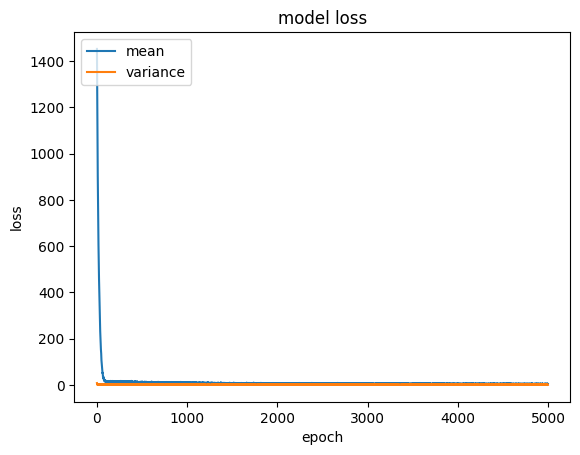

In [167]:
# Train
history, model = train_nn(X_train, Y_train, hidden_layers=[40, 100], epochs=5000, batch_size=15)
render_plot_loss(history)

In [ ]:
model.evaluate(x=X_test, y=Y_test)
predictions = model.predict_on_batch(X_test)

In [160]:
model.save(get_model_save_location(), save_format="h5")

## Generating GeoTIFFs from the DNN

All of the code from the following block is (temporarily) copy and pasted from the library files.

In [118]:
from dataclasses import dataclass
from osgeo import gdal, gdal_array
from tqdm import tqdm
import math

@dataclass
class AmazonGeoTiff:
  """Represents a geotiff from our dataset."""
  gdal_dataset: gdal.Dataset
  image_value_array: np.ndarray # ndarray of floats
  image_mask_array: np.ndarray # ndarray of uint8
  masked_image: np.ma.masked_array
  yearly_masked_image: np.ma.masked_array


@dataclass
class Bounds:
  """Represents geographic bounds and size information."""
  minx: float
  maxx: float
  miny: float
  maxy: float
  pixel_size_x: float
  pixel_size_y: float
  raster_size_x: float
  raster_size_y: float

def to_matplotlib(self) -> List[float]:
    return [self.minx, self.maxx, self.miny, self.maxy]

def load_raster(path: str, use_only_band_index: int = -1) -> AmazonGeoTiff:
  """
  TODO: Refactor (is_single_band, etc., should be a better design)
  --> Find a way to simplify this logic. Maybe it needs to be more abstract.
  """
  dataset = gdal.Open(path, gdal.GA_ReadOnly)
  image_datatype = dataset.GetRasterBand(1).DataType
  mask_datatype = dataset.GetRasterBand(1).GetMaskBand().DataType
  image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                   dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
  mask = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                  dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

  if use_only_band_index == -1:
    if dataset.RasterCount != 12 and dataset.RasterCount != 1:
      raise ValueError(f"Expected 12 raster bands (one for each month) or one annual average, but found {dataset.RasterCount}")
    if dataset.RasterCount == 1:
      use_only_band_index = 0

  is_single_band = use_only_band_index != -1

  if is_single_band and use_only_band_index >= dataset.RasterCount:
    raise IndexError(f"Specified raster band index {use_only_band_index}"
                     f" but there are only {dataset.RasterCount} rasters")

  for band_index in range(12):
    band = dataset.GetRasterBand(use_only_band_index+1 if is_single_band else band_index+1)
    image[:, :, band_index] = band.ReadAsArray()
    mask[:, :, band_index] = band.GetMaskBand().ReadAsArray()
  masked_image = np.ma.masked_where(mask == 0, image)
  yearly_masked_image = masked_image.mean(axis=2)

  return AmazonGeoTiff(dataset, image, mask, masked_image, yearly_masked_image)

def get_extent(dataset):
  geoTransform = dataset.GetGeoTransform()
  minx = geoTransform[0]
  maxy = geoTransform[3]
  maxx = minx + geoTransform[1] * dataset.RasterXSize
  miny = maxy + geoTransform[5] * dataset.RasterYSize
  return Bounds(minx, maxx, miny, maxy, geoTransform[1], geoTransform[5], dataset.RasterXSize, dataset.RasterYSize)

def coords_to_indices(bounds: Bounds, x: float, y: float):
  if x < bounds.minx or x > bounds.maxx or y < bounds.miny or y > bounds.maxy:
    raise ValueError("Coordinates out of bounds")

  # X => lat, Y => lon
  x_idx = bounds.raster_size_y - int(math.ceil((y - bounds.miny) / abs(bounds.pixel_size_y)))
  y_idx = int((x - bounds.minx) / abs(bounds.pixel_size_x))

  return x_idx, y_idx

def get_data_at_coords(dataset: AmazonGeoTiff, x: float, y: float, month: int) -> float:
  # x = longitude
  # y = latitude
  bounds = get_extent(dataset.gdal_dataset)
  x_idx, y_idx = coords_to_indices(bounds, x, y)
  if month == -1:
    value = dataset.yearly_masked_image[x_idx, y_idx]
  else:
    value = dataset.masked_image[x_idx, y_idx, month]
  if np.ma.is_masked(value):
    raise ValueError("Coordinates are masked")
  else:
    return value


The following code is new stuff, and used to generate a 12 GeoTIFFs (one for each month) from the model.

In [177]:
def get_predictions_at_each_pixel(
    monthly: bool,
    geotiffs: dict[str, AmazonGeoTiff],
    bounds: Bounds,
    model: keras.Model):
  feature_names = ["lat", "lon", "month_of_year"] + list(geotiffs.keys())
  predicted_means_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))
  predicted_vars_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))

  for month in range (0, 12 if monthly else 1):
    for x_idx, x in enumerate(tqdm(np.arange(bounds.minx, bounds.maxx, bounds.pixel_size_x, dtype=float))):
      rows = []
      row_indexes = []
      for y_idx, y in enumerate(np.arange(bounds.miny, bounds.maxy, -bounds.pixel_size_y, dtype=float)):
        row = {}
        try:
          for geotiff_label, geotiff in geotiffs.items():
            row[geotiff_label] = get_data_at_coords(geotiff, x, y, month)
          row["month_of_year"] = month
          row["lon"] = x
          row["lat"] = y
        except ValueError:
          continue # masked and out-of-bounds coordinates
        except IndexError:
          continue
        rows.append(row)
        row_indexes.append((y_idx,month,))
      if (len(rows) > 0):
        X = pd.DataFrame.from_dict(rows)
        predictions = model.predict_on_batch(X)

        means_np = predictions[0]
        for prediction, (y_idx, month_idx) in zip(means_np, row_indexes):
          predicted_means_np.mask[x_idx,y_idx,month_idx] = False # unmask since we have data
          predicted_means_np.data[x_idx,y_idx,month_idx] = prediction
        vars_np = predictions[1]
        for prediction, (y_idx, month_idx) in zip (vars_np, row_indexes):
          predicted_vars_np.mask[x_idx, y_idx, month_idx] = False
          predicted_vars_np.data[x_idx, y_idx, month_idx] = prediction

  return predicted_means_np, predicted_vars_np

In [178]:
from tensorflow import keras
model = keras.models.load_model(get_model_save_location(), custom_objects={"kl_divergence_loss": kl_divergence_loss})

relative_humidity_geotiff = load_raster(get_raster_path_from_params("R.rh_Stack.tif"))
temperature_geotiff = load_raster(get_raster_path_from_params("Temperatura_Stack.tif"))
vapor_pressure_deficit_geotiff = load_raster(get_raster_path_from_params("R.vpd_Stack.tif"))
atmosphere_isoscape_geotiff = load_raster(get_raster_path_from_params("Iso_Oxi_Stack.tif"))

name_to_geotiff = {
    "rh": relative_humidity_geotiff,
    "temp" : temperature_geotiff,
    "vpd" : vapor_pressure_deficit_geotiff,
    "atmosphere_oxygen_ratio" : atmosphere_isoscape_geotiff,
}

# We need the borders of the map. Pick one geotiff at random and use that as the extent.
bounds =  get_extent(atmosphere_isoscape_geotiff.gdal_dataset)

means_np, vars_np = get_predictions_at_each_pixel(
    monthly=True,
    geotiffs=name_to_geotiff,
    bounds=bounds,
    model=model)

100%|██████████| 940/940 [00:33<00:00, 27.96it/s]
